In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
import pandas as pd

In [2]:
def get_experiment_repeat_directories(exp_dir, repeat_prefix):
    exp_path = Path(exp_dir)
    sub_dirs = list(exp_path.glob("**"))
    repeat_dirs = []

    for d in sub_dirs:
        if repeat_prefix in d.stem:
            repeat_dirs.append(d.absolute())

    return repeat_dirs

def load_pickle(pickle_path):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
        return data
    

def load_all_particles(repeat_dirs):
    all_particles = []
    for d in repeat_dirs:
        particle_paths = d.glob("particles_*.pkl")
        for p_path in particle_paths:
            all_particles.extend(load_pickle(p_path))
            
    return all_particles

def filter_particles_by_distance(particles, epsilon):
    print(epsilon)
    filtered_particles = []
    for p in particles:
        flag = True
        for idx, eps in enumerate(epsilon):
            if p.distance[idx] > eps:
                flag = False
                
        if flag:
            filtered_particles.append(p)
    
    return filtered_particles

def get_solution_index(comm, sol_element_key):
    idx = comm.solution_keys.index(sol_element_key)
    return idx

def plot_particle_and_data(particle, exp_data_df, exp_sol_keys, exp_t_key, subplots_shape):
    sns.set_context("talk")
    sns.set_style("white")

    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4

    fig, axes = plt.subplots(nrows=subplots_shape[0], ncols=subplots_shape[1], figsize=(width_inches, height_inches))
    if isinstance(axes, np.ndarray):
        axes = axes.reshape(-1)
    
    else:
        axes = [axes]
    
    for idx, key_pair in enumerate(exp_sol_keys):
        ax = axes[idx]
        sol_idx = get_solution_index(particle, key_pair[1])
        print(key_pair, sol_idx)

        print(particle.sol[:, sol_idx].mean())
        sns.lineplot(x=particle.t, y=particle.sol[:, sol_idx].reshape(-1), 
                     label=f'sim_{sol_idx}', color='orange', ax=ax)
        ax.set_title(f"key:{key_pair[1]}, dist: {particle.distance[idx]:.4}")

        for idx, t in enumerate(exp_data_df[exp_t_key].values):
            
            exp_val = exp_data_df.loc[exp_data_df[exp_t_key] == t][
                key_pair[0]
            ].values[0]

            if np.isnan(exp_val):
                continue
            else:
                ax.scatter(t, exp_val, label=key_pair[0], color='black')
        
        ax.set(xlim=(-0.5,None))
        ax.set(ylim=(-0))
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_alpha(0.5)
        ax.spines["bottom"].set_alpha(0.5)
        ax.tick_params(labelsize=15)
        ax.margins(x=0)
        ax.margins(y=0)
        fig.tight_layout()

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())


def plot_all_particles(particles, exp_data_df, exp_sol_keys, exp_t_key, subplots_shape, color="orange"):
    sns.set_context("talk")
    sns.set_style("white")

    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4

    fig, axes = plt.subplots(nrows=subplots_shape[0], ncols=subplots_shape[1], figsize=(width_inches, height_inches))
    if isinstance(axes, np.ndarray):
        axes = axes.reshape(-1)
    
    else:
        axes = [axes]
    
    for idx, key_pair in enumerate(exp_sol_keys):
        ax = axes[idx]

        for particle in particles:
            sol_idx = get_solution_index(particle, key_pair[1])
            sns.lineplot(x=particle.t, y=particle.sol[:, sol_idx].reshape(-1), 
                         label=f'sim_{sol_idx}', color=color, alpha=0.25, ax=ax)
        ax.set_title(f"key:{key_pair[1]}, dist: {particle.distance[idx]:.4}")
        
        if exp_data_df is not None:
            for idx, t in enumerate(exp_data_df[exp_t_key].values):

                exp_val = exp_data_df.loc[exp_data_df[exp_t_key] == t][
                    key_pair[0]
                ].values[0]

                if np.isnan(exp_val):
                    continue
                else:
                    ax.scatter(t, exp_val, label=key_pair[0], color='black')
        
        ax.set(xlim=(-0.5,None))
        ax.set(ylim=(-0))
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_alpha(0.5)
        ax.spines["bottom"].set_alpha(0.5)
        ax.tick_params(labelsize=15)
        ax.margins(x=0)
        ax.margins(y=0)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
#         plt.legend(by_label.values(), by_label.keys())
        ax.legend(by_label.values(), by_label.keys())

        fig.tight_layout()
    
    return fig, axes

def generate_particle_parameter_df(particles):
    init_particle = particles[0]
    
    column_headings = [f'init_{x}' for x in init_particle.model_names]
    init_conc_cols = [f'init_{x}' for x in init_particle.dynamic_compounds]

    k_val_cols = []
    lb_constraint_cols = []
    
    for m in init_particle.model_names:
        # Make column headings
        k_val_cols += [f'K_{x}_{m}' for x in init_particle.dynamic_compounds]
        lb_constraint_cols += [f'lb_constr_{x}_{m}' for x in init_particle.dynamic_compounds] 

    column_headings += init_conc_cols + k_val_cols + lb_constraint_cols

    parameters = np.zeros([len(particles), len(column_headings)])
    for idx, p in enumerate(particles):
        parameters[idx] = p.generate_parameter_vector().reshape(-1)

    df = pd.DataFrame(data=parameters, columns=column_headings)
    return df


In [3]:
repeat_prefix = 'run_'

coculture_exp_dir = '../output/exp_lactis_iMM904_coculture_ga_fit/'
coculture_epsilon = [100.0, 0.20]
run_dirs = get_experiment_repeat_directories(coculture_exp_dir, repeat_prefix)
coculture_particles = load_all_particles(run_dirs)
coculture_particles = filter_particles_by_distance(coculture_particles, epsilon=coculture_epsilon)


yeast_exp_dir = '../output/exp_yeast_ga_fit/'
yeast_epsilon = [1.0]
run_dirs = get_experiment_repeat_directories(yeast_exp_dir, repeat_prefix)
yeast_particles = load_all_particles(run_dirs)
yeast_particles = filter_particles_by_distance(yeast_particles, epsilon=yeast_epsilon)

lactis_exp_dir = '../output/exp_lactis_ga_fit/'
lactis_epsilon = [0.01]
run_dirs = get_experiment_repeat_directories(lactis_exp_dir, repeat_prefix)
lactis_particles = load_all_particles(run_dirs)
lactis_particles = filter_particles_by_distance(lactis_particles, epsilon=lactis_epsilon)


print(len(coculture_particles))
print(len(yeast_particles))
print(len(lactis_particles))

[100.0, 0.2]
[1.0]
[0.01]
860
1140
859


In [4]:
exp_sol_keys = [
    ["yeast_dcw", "iMM904"],
    ["lactis_dcw", "L_lactis_fbc"],
]


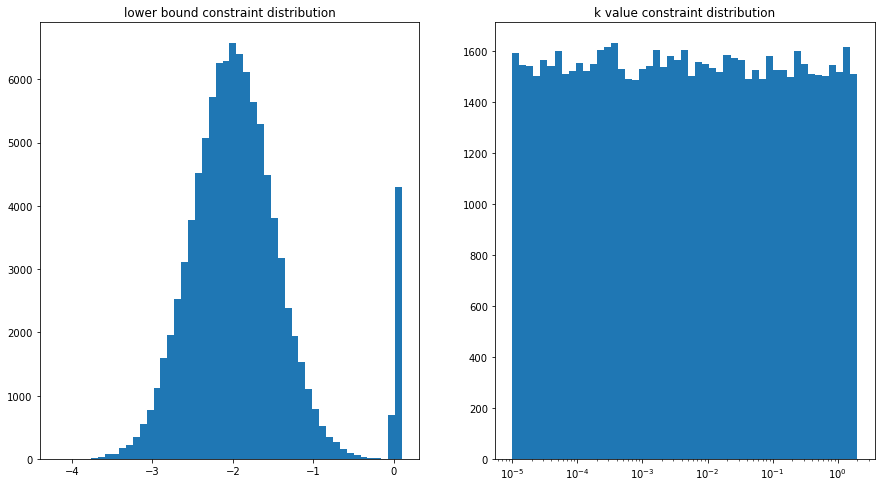

In [5]:
from bk_comms import sampling
dist_1 = sampling.SampleSkewNormal(loc=-2.0, scale=0.5, alpha=0.0)
dist_2 = sampling.SampleUniform(1e-3, 1e-1)

max_uptake_sampler = sampling.MultiDistribution(dist_1, dist_2, 0.95)
k_val_sampler = sampling.SampleUniform(min_val=1e-5, 
                                       max_val=100.0, distribution_type='log_uniform')

lb_sample = max_uptake_sampler.sample(size=[100000,1])
k_sample = k_val_sampler.sample(size=[100000,1])

width_inches = 95*4 / 25.4
height_inches = 51*4 / 25.4


fig, ax = plt.subplots(ncols=2, figsize=(width_inches, height_inches))
ax[0].set_title('lower bound constraint distribution')
ax[1].set_title('k value constraint distribution')

_ = ax[0].hist(lb_sample, bins=50)

bins=np.logspace(np.log10(1e-5),np.log10(2.0), 50)

_ = ax[1].hist(k_sample, bins=bins)
ax[1].set_xscale('log')


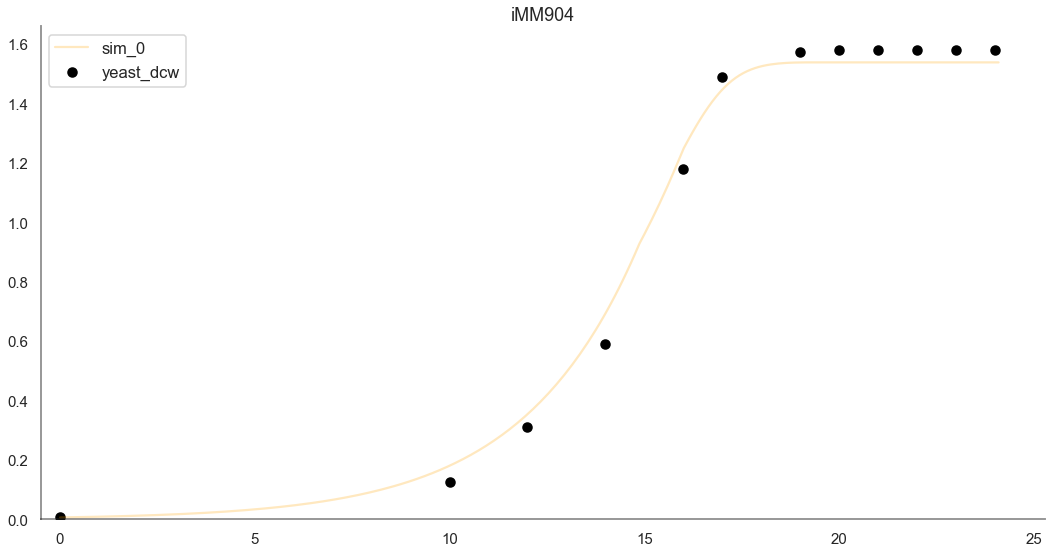

In [6]:
# Yeast plot
yeast_exp_sol_keys = [
    ["yeast_dcw", "iMM904"],
]
exp_data = pd.read_csv("../experimental_data/Figure1B_fake_data.csv")

fig, axes = plot_all_particles(particles=[yeast_particles[150]], exp_data_df=exp_data, exp_t_key='time', 
                   exp_sol_keys=yeast_exp_sol_keys, subplots_shape=[1, 1])
axes[0].set_title('iMM904');

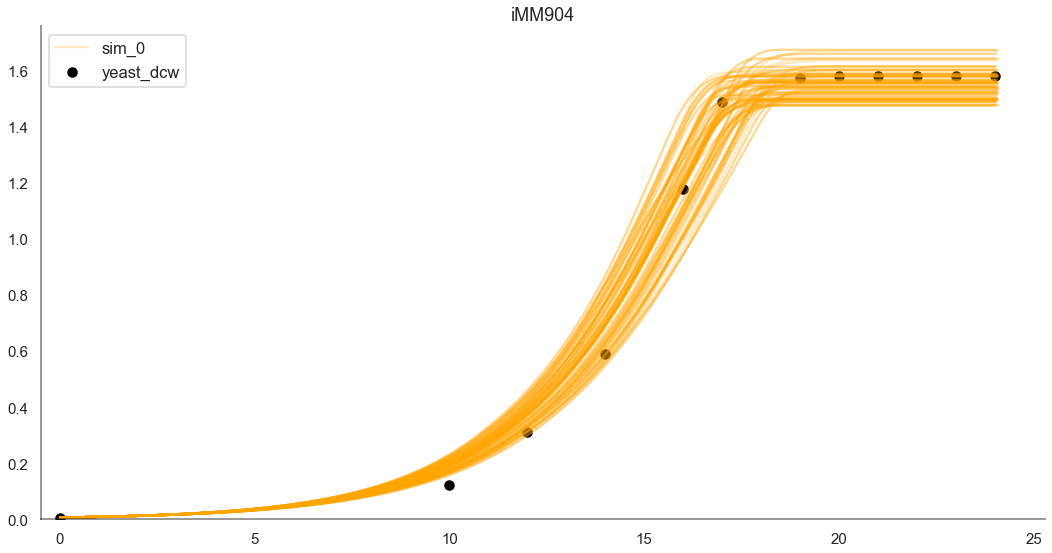

In [7]:
# Yeast plot
yeast_exp_sol_keys = [
    ["yeast_dcw", "iMM904"],
]
exp_data = pd.read_csv("../experimental_data/Figure1B_fake_data.csv")

fig, axes = plot_all_particles(particles=yeast_particles[:100], exp_data_df=exp_data, exp_t_key='time', 
                   exp_sol_keys=yeast_exp_sol_keys, subplots_shape=[1, 1])
axes[0].set_title('iMM904');

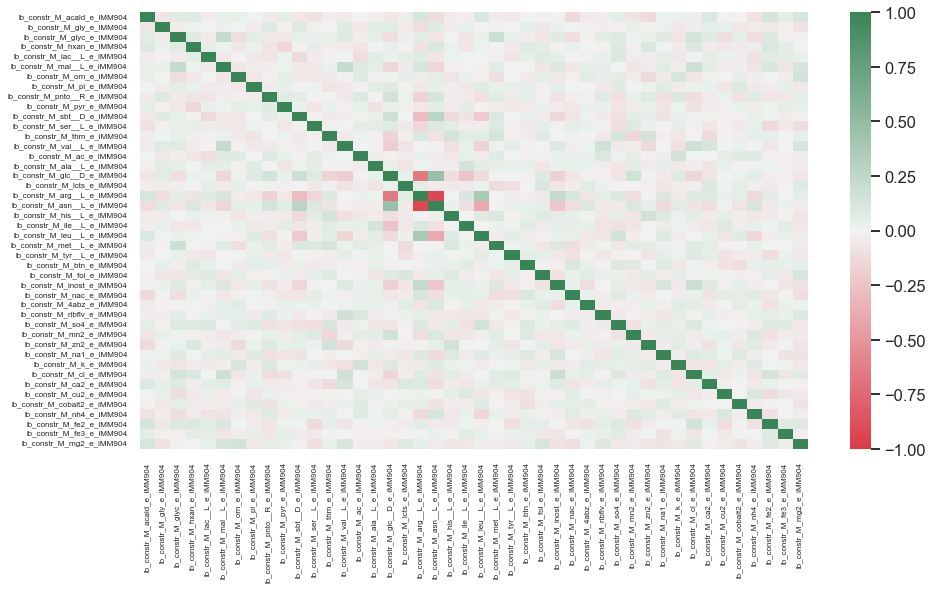

In [8]:
def plot_correlation_heatmap(df):
    # Colors

    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4

    fig, ax = plt.subplots(figsize=(width_inches, height_inches))
    cmap = sns.diverging_palette(500, 10, as_cmap=True).reversed()
    ax.tick_params(labelsize=8)
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False, cmap=cmap, ax=ax)

df = generate_particle_parameter_df(yeast_particles)
lb_constr_columns = [x for x in df.columns if 'lb_constr_' in x]
lb_constr_sub_df = df[lb_constr_columns]
plot_correlation_heatmap(lb_constr_sub_df)

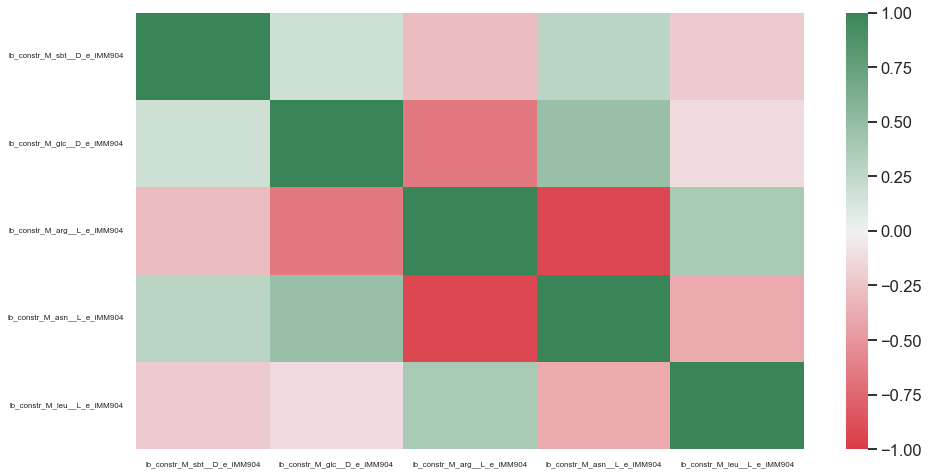

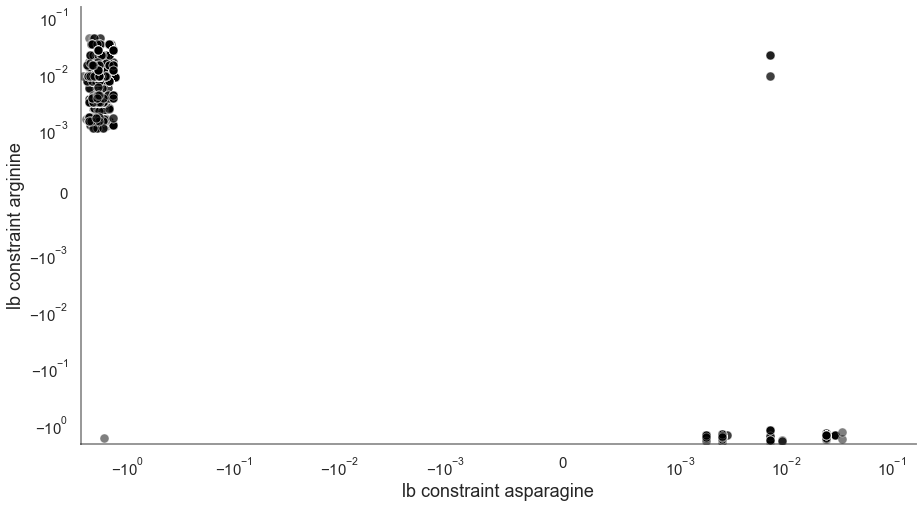

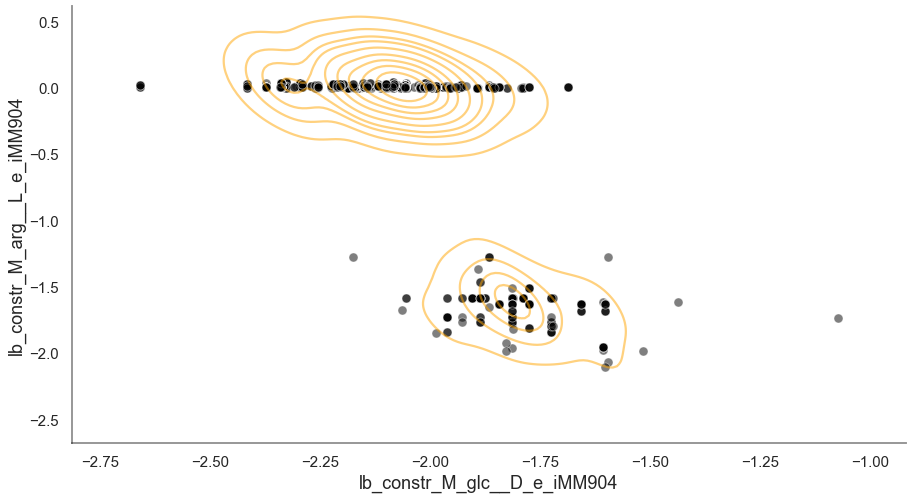

In [37]:
width_inches = 95*4 / 25.4
height_inches = 51*4 / 25.4


df = generate_particle_parameter_df(yeast_particles)
lb_constr_columns = [x for x in df.columns if 'lb_constr_' in x]
lb_constr_sub_df = df[lb_constr_columns]

keep_cols = []
for c in lb_constr_sub_df.columns:
    x = (abs(lb_constr_sub_df.corr()[c].replace(1.0, 0.0)).max())
    if (lb_constr_sub_df.corr()[c].replace(1.0, 0.0).max() > 0.25):
        keep_cols.append(c)

plot_correlation_heatmap(lb_constr_sub_df[keep_cols])

# for param in keep_cols:
fig, ax = plt.subplots(figsize=(width_inches, height_inches))

# sns.histplot(monoculture_yeast_df, x=param, bins=25, 
#                  ax=ax, color='orange', stat='density', alpha=0.5)
# sns.histplot(coculture_yeast_df, x=param, bins=25, 
#                  ax=ax, stat='density', alpha=0.5)

# sns.kdeplot(data=df, x='lb_constr_M_asn__L_e_iMM904', y='lb_constr_M_arg__L_e_iMM904',
#          ax=ax, color='orange', alpha=0.5)
sns.scatterplot(data=df, x='lb_constr_M_asn__L_e_iMM904', y='lb_constr_M_arg__L_e_iMM904',
         ax=ax, color='black', alpha=0.5)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_alpha(0.5)
ax.spines["bottom"].set_alpha(0.5)
ax.tick_params(labelsize=15)
plt.xscale('symlog', linthresh=1.e-3)
plt.yscale('symlog', linthresh=1.e-3)


ax.set_ylabel('lb constraint arginine')
ax.set_xlabel('lb constraint asparagine')
plt.show()

fig, ax = plt.subplots(figsize=(width_inches, height_inches))

# sns.histplot(monoculture_yeast_df, x=param, bins=25, 
#                  ax=ax, color='orange', stat='density', alpha=0.5)
# sns.histplot(coculture_yeast_df, x=param, bins=25, 
#                  ax=ax, stat='density', alpha=0.5)

sns.kdeplot(data=df, x='lb_constr_M_glc__D_e_iMM904', y='lb_constr_M_arg__L_e_iMM904',
         ax=ax, color='orange', alpha=0.5)

sns.scatterplot(data=df, x='lb_constr_M_glc__D_e_iMM904', y='lb_constr_M_arg__L_e_iMM904',
         ax=ax, color='black', alpha=0.5)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_alpha(0.5)
ax.spines["bottom"].set_alpha(0.5)
ax.tick_params(labelsize=15)



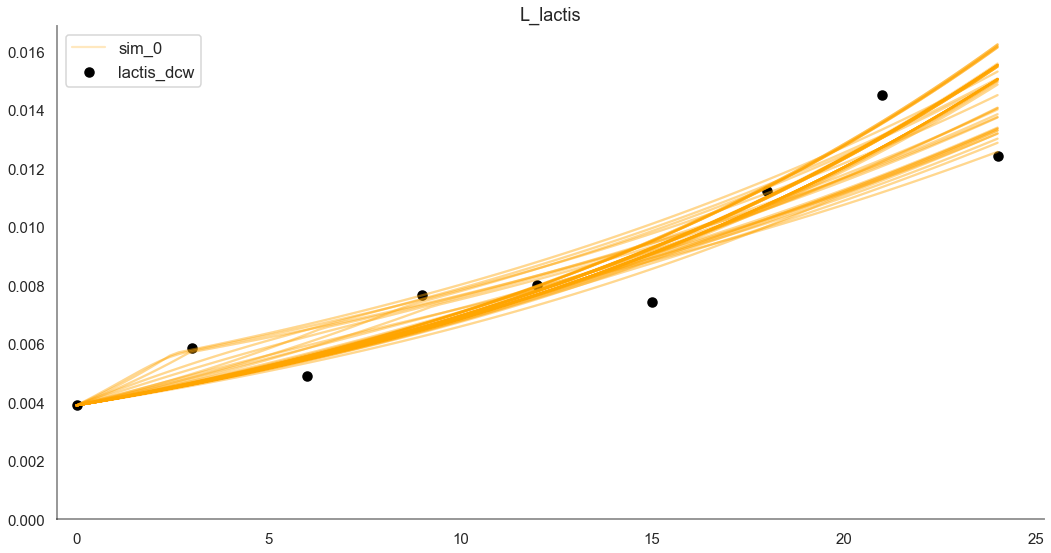

In [10]:
# lactis plot
lactis_exp_sol_keys = [
    ["lactis_dcw", "L_lactis_fbc"]
]
exp_data = pd.read_csv("../experimental_data/Figure1B_fake_data.csv")

fig, axes = plot_all_particles(particles=lactis_particles[:100], exp_data_df=exp_data, exp_t_key='time', 
                   exp_sol_keys=lactis_exp_sol_keys, subplots_shape=[1, 1])
axes[0].set_title('L_lactis');

{'sim_0': <matplotlib.lines.Line2D object at 0x7fe30195afa0>}


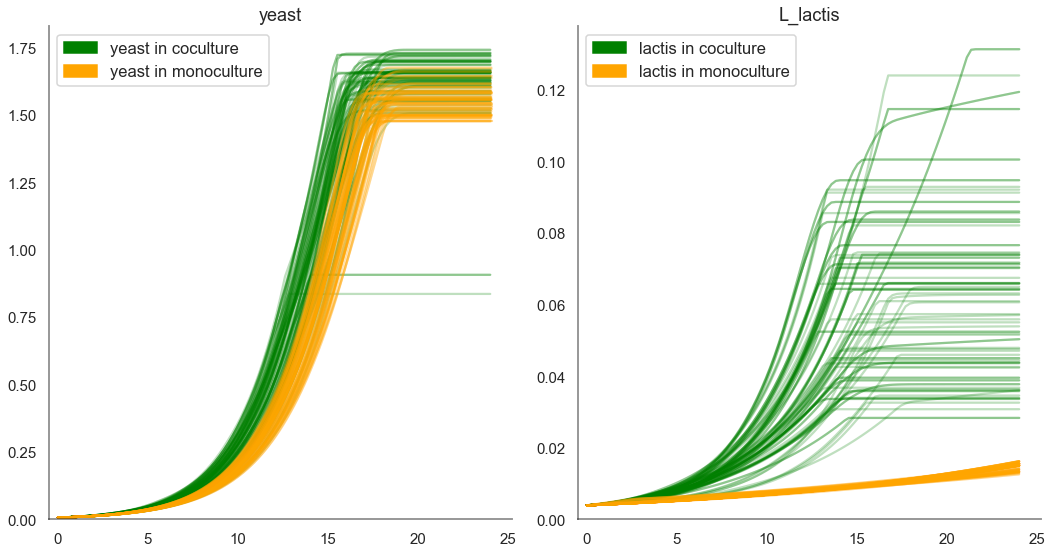

In [11]:
# lactis plot
coculture_sol_keys = [
    ["yeast_dcw", "iMM904"],
    ["lactis_dcw", "L_lactis_fbc"],
]
exp_data = pd.read_csv("../experimental_data/Figure1B_fake_data.csv")

fig, axes = plot_all_particles(particles=coculture_particles[:100], exp_data_df=None, exp_t_key='time', 
                   exp_sol_keys=coculture_sol_keys, subplots_shape=[1, 2], color='green')

for particle in yeast_particles[:100]:
    sol_idx = get_solution_index(particle, yeast_exp_sol_keys[0][1])
    sns.lineplot(x=particle.t, y=particle.sol[:, sol_idx].reshape(-1), 
                 label=f'sim_{sol_idx}', color='orange', alpha=0.25, ax=axes[0])


for particle in lactis_particles[:100]:
    sol_idx = get_solution_index(particle, lactis_exp_sol_keys[0][1])
    sns.lineplot(x=particle.t, y=particle.sol[:, sol_idx].reshape(-1), 
                 label=f'sim_{sol_idx}', color='orange', alpha=0.25, ax=axes[1])

    
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

print(by_label)
axes[1].legend(by_label.values(), by_label.keys())

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[0].legend(by_label.values(), by_label.keys())



axes[0].set_title('yeast')
axes[1].set_title('L_lactis')

import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='orange', label='yeast in monoculture')
orange_patch = mpatches.Patch(color='green', label='yeast in coculture')
axes[0].legend(handles=[orange_patch, green_patch])

import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='orange', label='lactis in monoculture')
orange_patch = mpatches.Patch(color='green', label='lactis in coculture')
axes[1].legend(handles=[orange_patch, green_patch])

fig.tight_layout()


In [12]:
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
import scipy


coculture_df = generate_particle_parameter_df(coculture_particles)
yeast_mono_df = generate_particle_parameter_df(yeast_particles)

yeast_cols = [c for c in coculture_df.columns if 'iMM904' in c]
yeast_cols = [c for c in yeast_cols if 'lb_constr' in c]

coculture_yeast_df = coculture_df[yeast_cols]
monoculture_yeast_df = yeast_mono_df[yeast_cols]

common_columns = monoculture_yeast_df.columns
p_values = []
ks_values = []
for c in common_columns:
    mono_vals = monoculture_yeast_df[c].values
    cocul_vals = coculture_yeast_df[c].values

    x = scipy.stats.ks_2samp(mono_vals, cocul_vals)
    p_values.append(x.pvalue)
    ks_values.append(x.statistic)

ks_df = pd.DataFrame({'parameter': common_columns, 'ks': ks_values, 'p': p_values})
ks_df.sort_values('ks', ascending=False, inplace=True)

with pd.option_context('display.max_rows', 25, 'display.max_columns', None):  # more options can be specified also
    print(ks_df.sort_values('ks', ascending=False))


                      parameter        ks         p
0    lb_constr_M_acald_e_iMM904  0.086638  0.001177
5   lb_constr_M_mal__L_e_iMM904  0.062770  0.039809
43     lb_constr_M_mg2_e_iMM904  0.059710  0.057651
36      lb_constr_M_cl_e_iMM904  0.059670  0.057929
10  lb_constr_M_sbt__D_e_iMM904  0.057711  0.072702
..                          ...       ...       ...
4   lb_constr_M_lac__L_e_iMM904  0.024847  0.912983
27   lb_constr_M_inost_e_iMM904  0.024623  0.918219
19  lb_constr_M_asn__L_e_iMM904  0.024051  0.930761
25     lb_constr_M_btn_e_iMM904  0.021053  0.977526
9      lb_constr_M_pyr_e_iMM904  0.020420  0.983460

[44 rows x 3 columns]


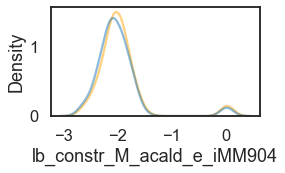

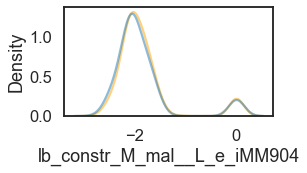

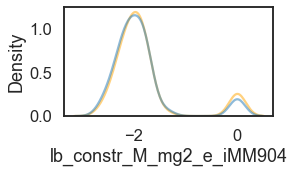

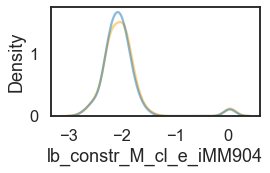

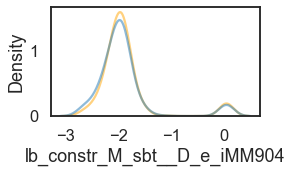

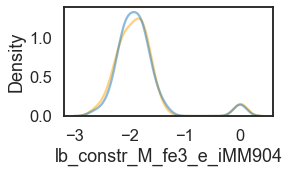

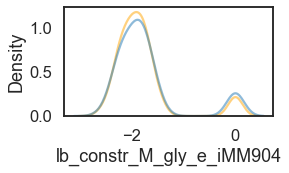

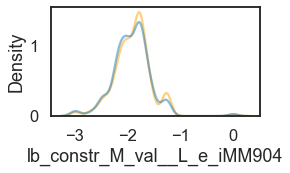

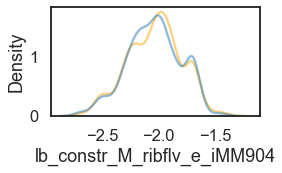

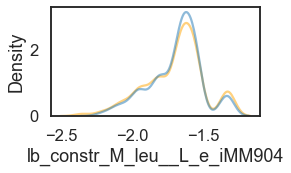

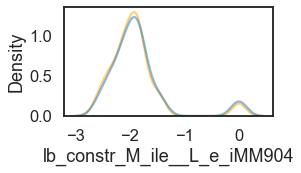

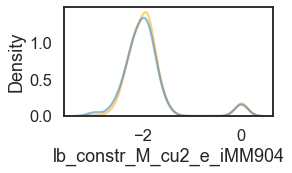

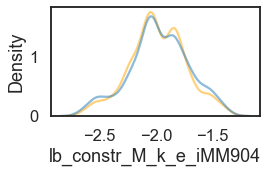

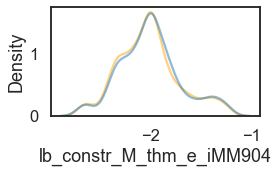

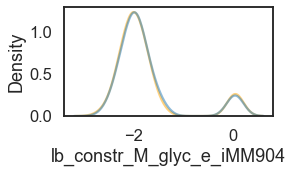

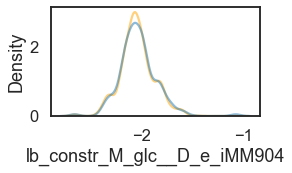

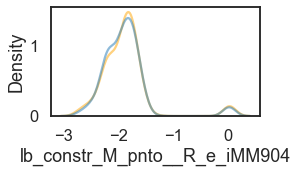

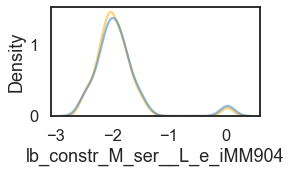

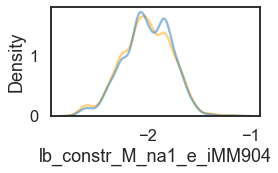

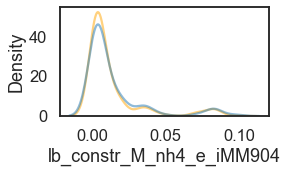

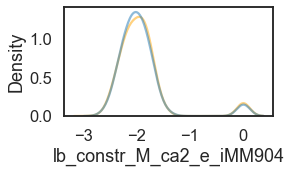

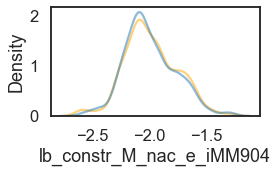

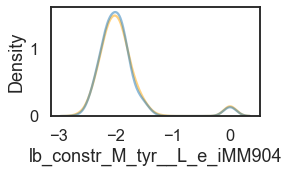

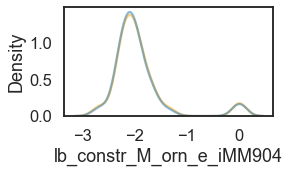

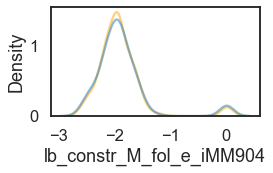

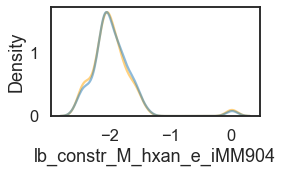

In [13]:
sns.set_context("talk")
sns.set_style("white")

width_inches = 95 / 25.4
height_inches = 51 / 25.4


for idx, param in enumerate(ks_df.parameter.values):
    fig, ax = plt.subplots(figsize=(width_inches, height_inches))

    # sns.histplot(monoculture_yeast_df, x=param, bins=25, 
    #                  ax=ax, color='orange', stat='density', alpha=0.5)
    # sns.histplot(coculture_yeast_df, x=param, bins=25, 
    #                  ax=ax, stat='density', alpha=0.5)
    
    sns.kdeplot(data=monoculture_yeast_df, x=param, 
             ax=ax, color='orange', alpha=0.5)
    sns.kdeplot(data=coculture_yeast_df, x=param,
                 ax=ax, alpha=0.5)

    plt.show()
    plt.close()
    
    if idx == 25:
        break

In [14]:
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
import scipy


coculture_df = generate_particle_parameter_df(coculture_particles)
lactis_mono_df = generate_particle_parameter_df(lactis_particles)

lactis_cols = [c for c in coculture_df.columns if 'lactis' in c]
lactis_cols = [c for c in lactis_cols if 'lb_constr' in c]

coculture_lactis_df = coculture_df[lactis_cols]
monoculture_lactis_df = lactis_mono_df[lactis_cols]

common_columns = monoculture_lactis_df.columns
p_values = []
ks_values = []
for c in common_columns:
    mono_vals = monoculture_lactis_df[c].values
    cocul_vals = coculture_lactis_df[c].values

    x = scipy.stats.ks_2samp(mono_vals, cocul_vals)
    p_values.append(x.pvalue)
    ks_values.append(x.statistic)

ks_df = pd.DataFrame({'parameter': common_columns, 'ks': ks_values, 'p': p_values})
ks_df.sort_values('ks', ascending=False, inplace=True)

with pd.option_context('display.max_rows', 25, 'display.max_columns', None):  # more options can be specified also
    print(ks_df.sort_values('ks', ascending=False))


                             parameter        ks             p
5    lb_constr_M_mal__L_e_L_lactis_fbc  0.495176  6.895186e-98
27    lb_constr_M_inost_e_L_lactis_fbc  0.493997  2.156247e-97
26      lb_constr_M_fol_e_L_lactis_fbc  0.491645  2.072894e-96
13   lb_constr_M_val__L_e_L_lactis_fbc  0.467131  1.609551e-86
39  lb_constr_M_cobalt2_e_L_lactis_fbc  0.447421  4.990461e-79
..                                 ...       ...           ...
12      lb_constr_M_thm_e_L_lactis_fbc  0.200858  1.106162e-15
35        lb_constr_M_k_e_L_lactis_fbc  0.187877  9.614531e-14
31      lb_constr_M_so4_e_L_lactis_fbc  0.177137  3.122502e-12
9       lb_constr_M_pyr_e_L_lactis_fbc  0.170308  2.542033e-11
43      lb_constr_M_mg2_e_L_lactis_fbc  0.161979  2.693360e-10

[44 rows x 3 columns]


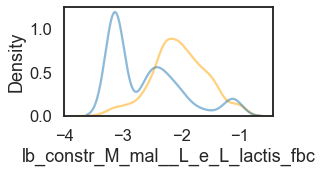

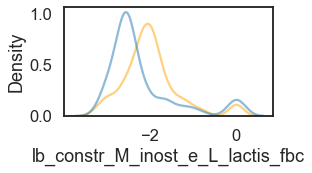

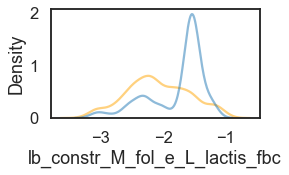

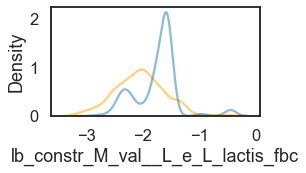

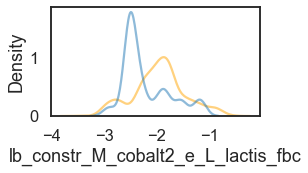

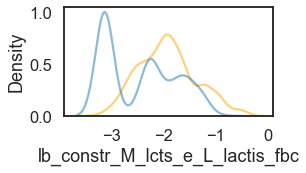

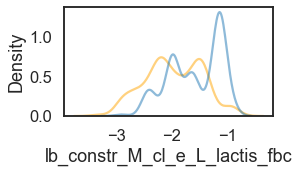

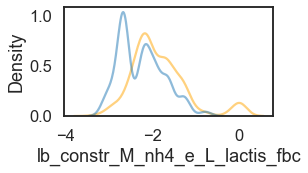

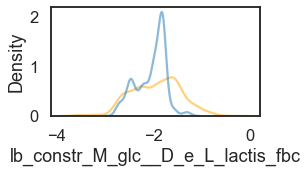

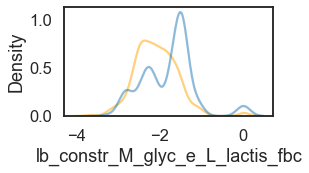

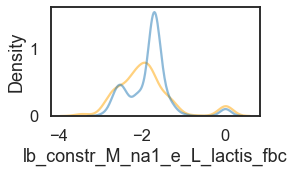

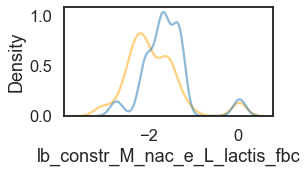

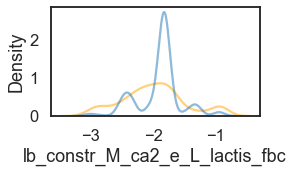

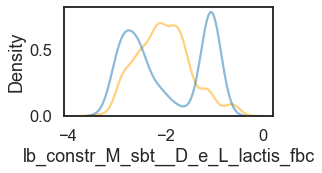

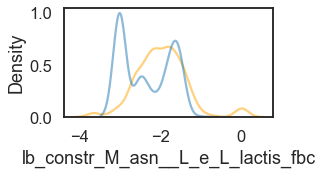

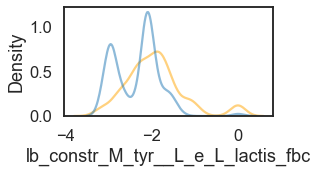

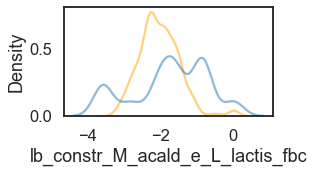

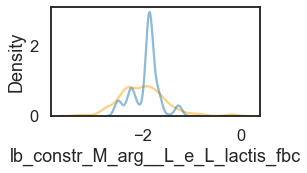

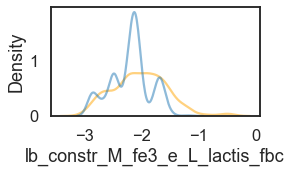

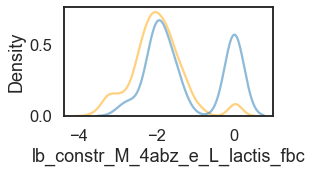

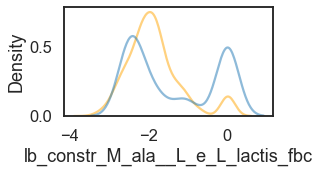

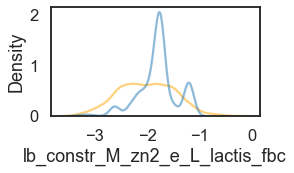

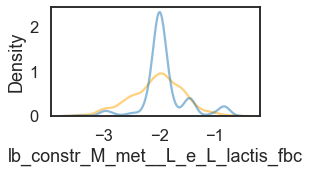

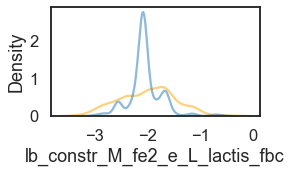

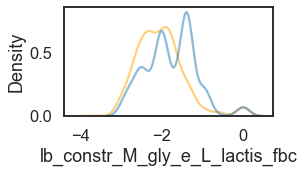

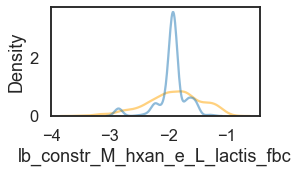

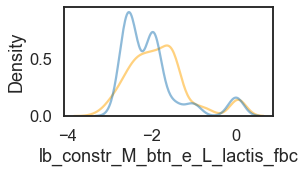

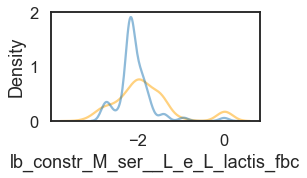

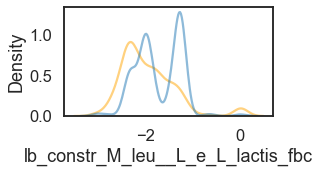

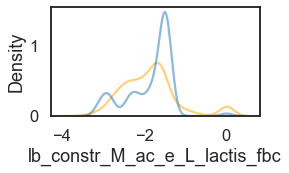

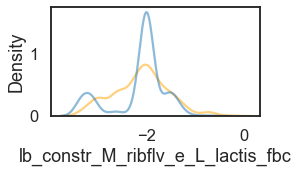

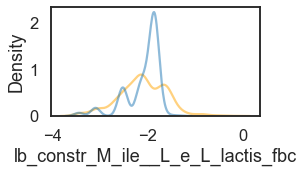

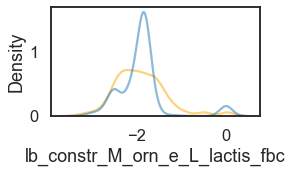

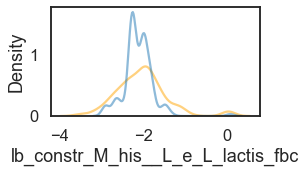

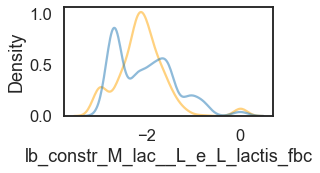

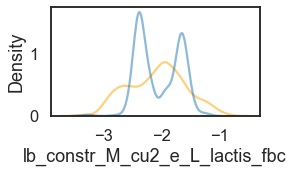

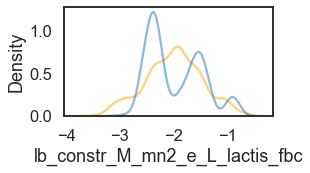

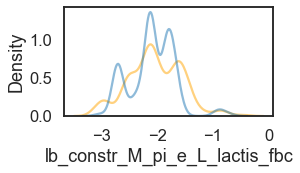

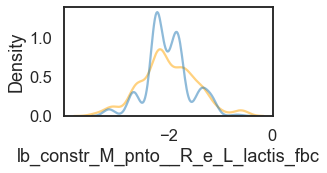

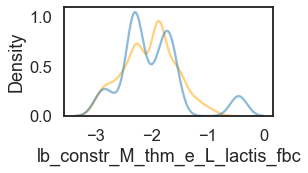

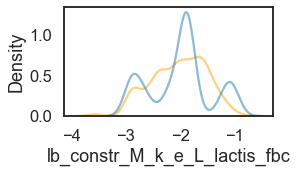

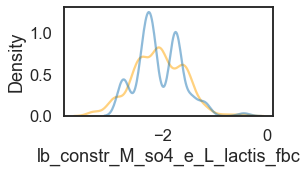

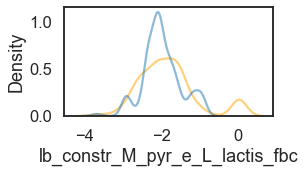

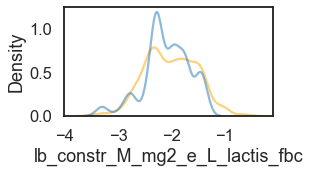

In [15]:
sns.set_context("talk")
sns.set_style("white")

width_inches = 95 / 25.4
height_inches = 51 / 25.4

for idx, param in enumerate(ks_df.parameter.values):
    fig, ax = plt.subplots(figsize=(width_inches, height_inches))

#     sns.histplot(monoculture_lactis_df, x=param, bins=25, 
#                  ax=ax, color='orange', stat='density', alpha=0.5)
#     sns.histplot(coculture_lactis_df, x=param, bins=25, 
#                  ax=ax, stat='density', alpha=0.5)

    sns.kdeplot(data=monoculture_lactis_df, x=param, 
             ax=ax, color='orange', alpha=0.5)
    sns.kdeplot(data=coculture_lactis_df, x=param,
                 ax=ax, alpha=0.5)

    plt.show()
    plt.close()
    


In [80]:
def plot_pca(df, labels=None):
    from sklearn import decomposition
    from sklearn import datasets
    pca = decomposition.PCA(n_components=2)
    pca.fit(df)
    X = pca.transform(df)
    
    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4

    fig, ax = plt.subplots(figsize=(width_inches, height_inches))
    ax.scatter(x=X[:, 0], y=X[:, 1], s=2.5,c=labels, cmap='Spectral')

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_alpha(0.5)
    ax.spines["bottom"].set_alpha(0.5)
    ax.tick_params(labelsize=15)
    fig.tight_layout()

def plot_tsne(df):
    from sklearn import manifold
    tsne = manifold.TSNE(n_components=2, n_jobs=5).fit_transform(df)
    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4

    fig, ax = plt.subplots(figsize=(width_inches, height_inches))
    ax.scatter(x=tsne[:, 0], y=tsne[:, 1], s=2.5)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_alpha(0.5)
    ax.spines["bottom"].set_alpha(0.5)
    ax.tick_params(labelsize=15)
    fig.tight_layout()
    
def plot_umap(df, labels=None):
    import umap
    width_inches = 95*4 / 25.4
    height_inches = 51*4 / 25.4
    from matplotlib.colors import ListedColormap
    cmp=ListedColormap(['red','green'])
    
    fit = umap.UMAP()
    u = fit.fit_transform(df)
    
    fig, ax = plt.subplots(figsize=(width_inches, height_inches))
    ax.scatter(x=u[:, 0], y=u[:, 1], c=labels, cmap=cmp, s=2.5)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_alpha(0.5)
    ax.spines["bottom"].set_alpha(0.5)
    ax.tick_params(labelsize=15)
    fig.tight_layout()


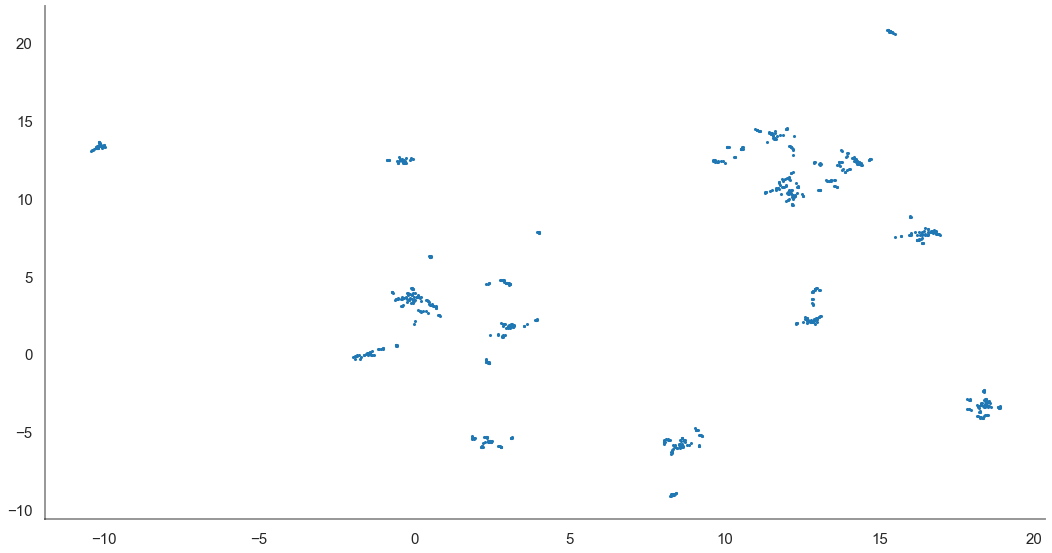

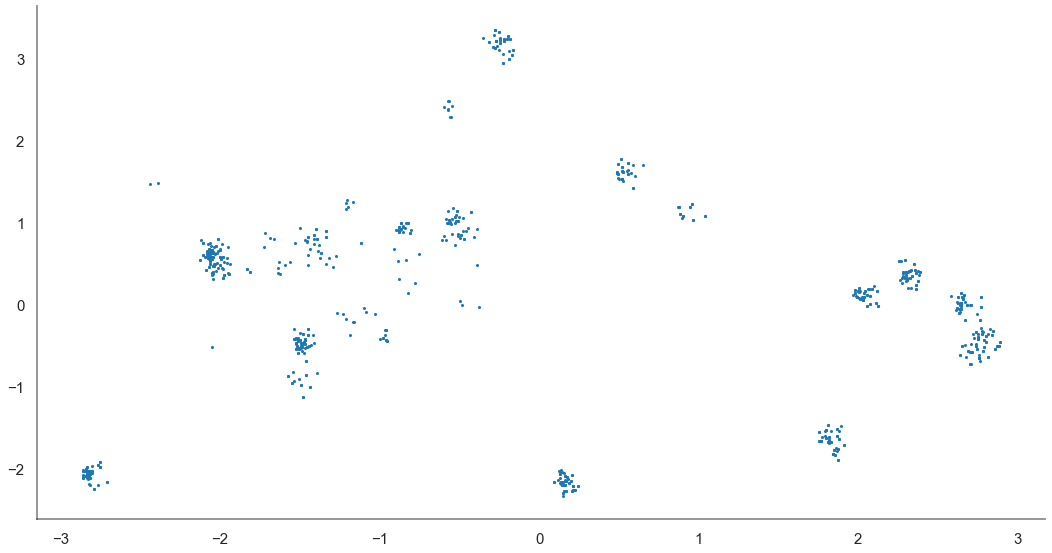

In [81]:
lb_constr_cols = [c for c in coculture_df.columns if 'lb_constr' in c]
plot_umap(coculture_df[lb_constr_cols])
plot_pca(coculture_df[lb_constr_cols])

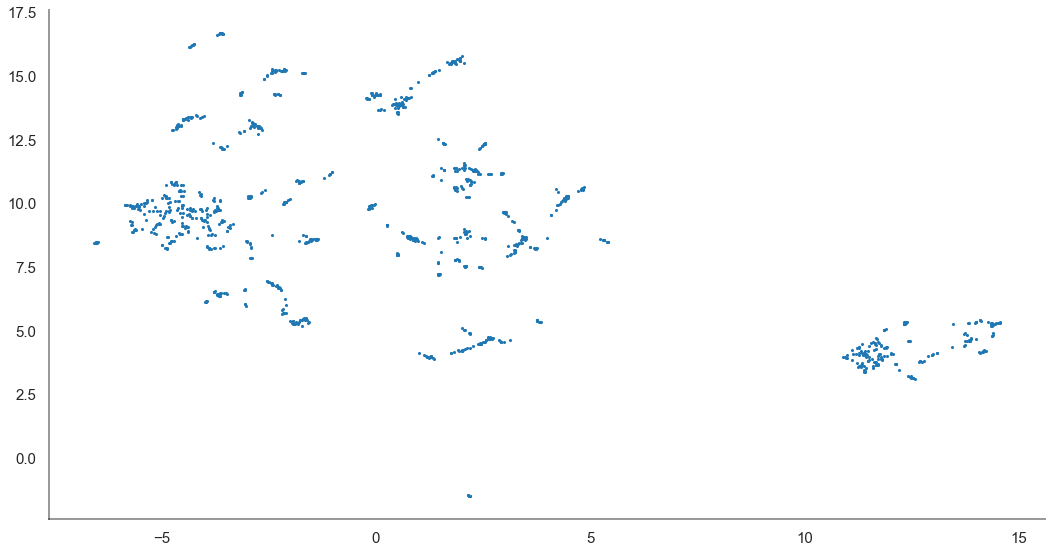

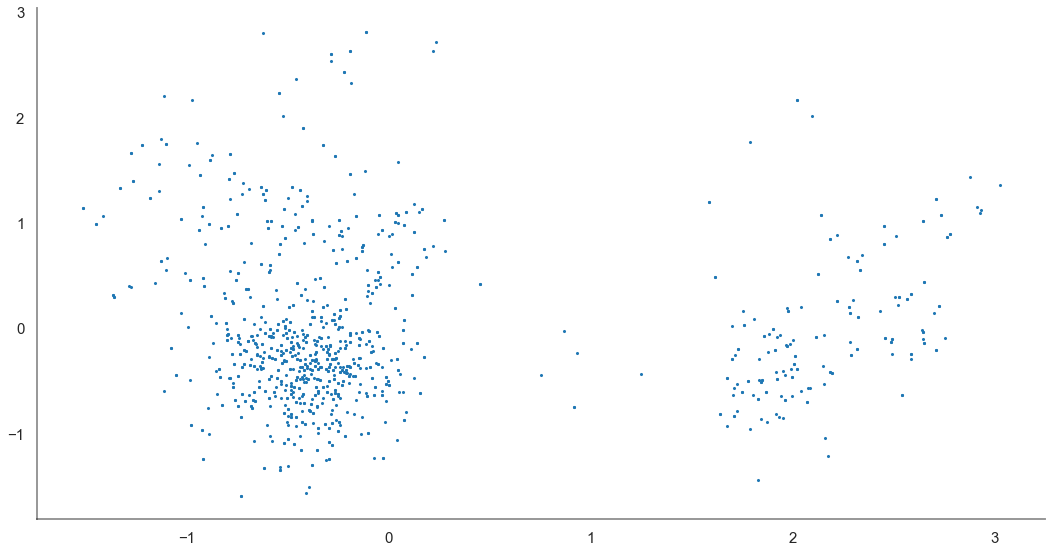

In [82]:
lb_constr_cols = [c for c in monoculture_yeast_df.columns if 'lb_constr' in c]
plot_umap(monoculture_yeast_df[lb_constr_cols])
plot_pca(monoculture_yeast_df[lb_constr_cols])


/var/folders/59/mfl58qxj151bv31dsnfrs1lh0000gn/T/ipykernel_56986/3161966669.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monoculture_yeast_df['in_coculture'] = is_in_coculture


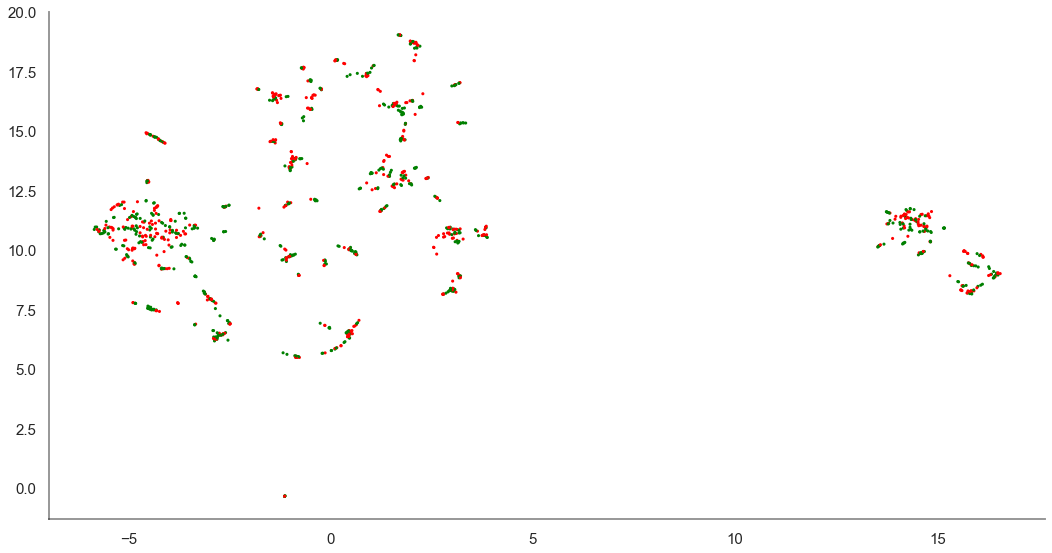

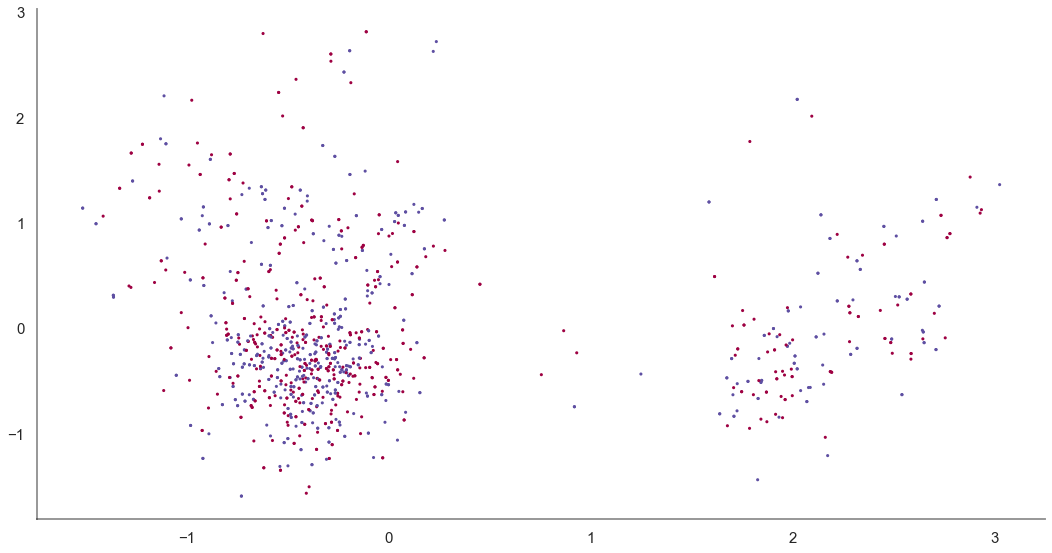

In [83]:
param_cols = [c for c in coculture_df.columns if 'lb_constr' in c]
param_cols = [c for c in param_cols if 'iMM904' in c] 

is_in_coculture = np.zeros(len(monoculture_yeast_df))

for _, row in coculture_df.iterrows():
    test_vector = row[param_cols]
    
    for idx, row in monoculture_yeast_df.iterrows():
        if np.array_equal(row[param_cols].values, test_vector):
            is_in_coculture[idx] = 1

monoculture_yeast_df['in_coculture'] = is_in_coculture
plot_umap(monoculture_yeast_df.drop('in_coculture', axis=1), labels=monoculture_yeast_df['in_coculture'])
plot_pca(monoculture_yeast_df.drop('in_coculture', axis=1), labels=monoculture_yeast_df['in_coculture'])

/var/folders/59/mfl58qxj151bv31dsnfrs1lh0000gn/T/ipykernel_56986/3525903816.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monoculture_lactis_df['in_coculture'] = is_in_coculture


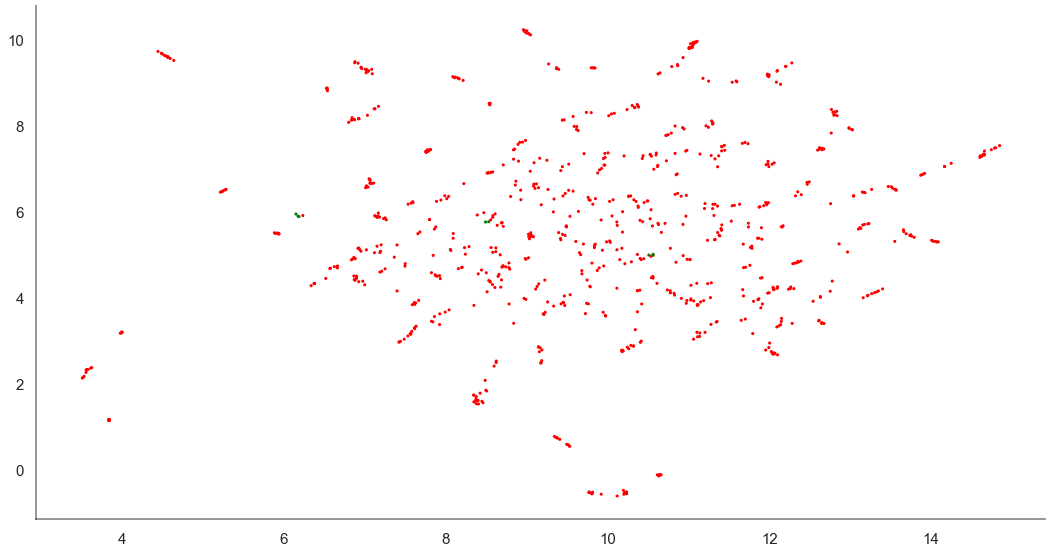

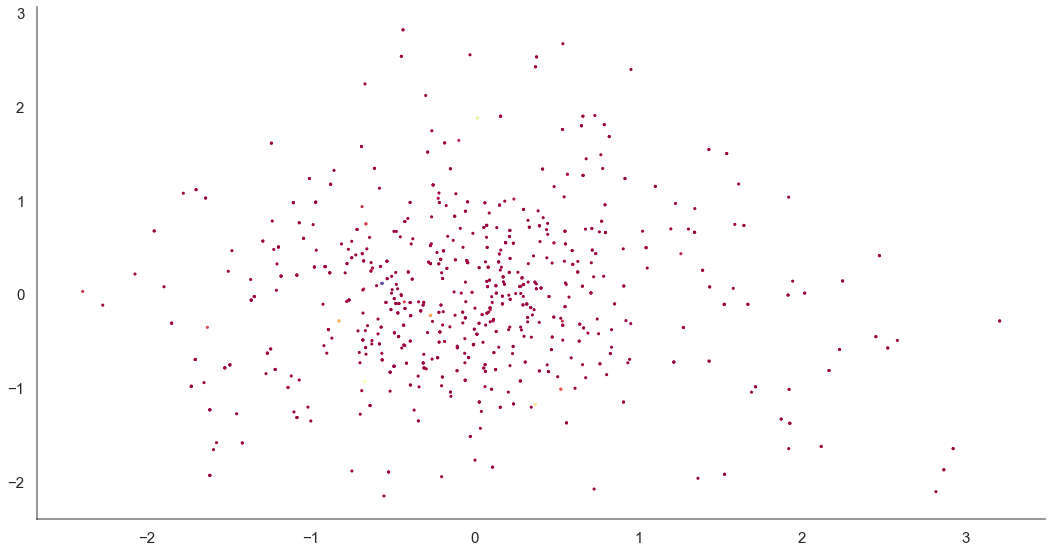

In [90]:
param_cols = [c for c in coculture_df.columns if 'lb_constr' in c]
param_cols = [c for c in param_cols if 'lactis' in c] 

is_in_coculture = np.zeros(len(monoculture_lactis_df))

for _, row in coculture_df.iterrows():
    test_vector = row[param_cols]
    
    for idx, row in monoculture_lactis_df.iterrows():
        if np.array_equal(row[param_cols].values, test_vector):
            is_in_coculture[idx] += 1

monoculture_lactis_df['in_coculture'] = is_in_coculture
plot_umap(monoculture_lactis_df.drop('in_coculture', axis=1), labels=monoculture_lactis_df['in_coculture'])
plot_pca(monoculture_lactis_df.drop('in_coculture', axis=1), labels=monoculture_lactis_df['in_coculture'])


In [91]:
monoculture_lactis_df['in_coculture'].sum()

731.0

In [86]:
monoculture_yeast_df['in_coculture'].sum()

595.0

In [109]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', None):  # more options can be specified also
    x = (monoculture_lactis_df.sort_values('in_coculture', ascending=False)['in_coculture'])
    for i in x:
        print(i)

70.0
70.0
70.0
41.0
41.0
36.0
36.0
36.0
30.0
30.0
30.0
23.0
23.0
23.0
20.0
20.0
20.0
11.0
11.0
8.0
7.0
7.0
7.0
6.0
6.0
5.0
5.0
4.0
4.0
4.0
3.0
3.0
3.0
3.0
3.0
2.0
2.0
2.0
2.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0